In [2]:
# importing the required libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures

In [3]:
# Importing the dataset
df = pd.read_csv("phishing_dataset.csv")
df.pop("id")
df.pop("RightClick")
df.pop("Iframe")
df.pop("on_mouseover")
df.pop("Favicon")
df["Result"].replace(-1, 0, inplace=True)
df.head()

KeyError: 'OnMouseOver'

In [5]:
# Separating the data into X and y
logistic_df = df.copy(deep=True)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [6]:
# Splitting the dataset into the Training set, Validation set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

y_2d_train= y_train.reshape(-1, 1)
y_2d_test = y_test.reshape(-1, 1)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
ones = np.ones((X_train.shape[0], 1))
X_train_1 = np.hstack((ones, X_train))

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [9]:
w_init = np.zeros((X_train_1.shape[1], 1))

In [10]:
def hypothesis(X, w):
    return sigmoid(np.dot(X, w))

In [11]:
y_hat_init = hypothesis(X_train_1,w_init)

In [12]:
def log_likelihood(X, y, w):
    return np.sum(y * np.log(hypothesis(X, w)) + (1 - y) * np.log(1 - hypothesis(X, w)))

In [13]:
def Gradient_Ascent(X, y, learning_rate, num_iters):
    N = X.shape[0]
    w = np.zeros((X.shape[1],1))
    
    # Gradient Ascent - local optimization technique
    for _ in range(num_iters):
        w = w + (learning_rate / N) * (X.T.dot(y - hypothesis(X, w)))

    return w

In [14]:
learning_rate = 0.03
num_iters = 3000
# Calculate w and likelihood values using Gradient_Ascent with X_train_1, y_2d_train
w = Gradient_Ascent(X_train_1, y_2d_train, learning_rate, num_iters)

In [15]:
def predict_class(X, w, t):
    prediction = hypothesis(X, w)
    return np.where(prediction >= t, 1, 0)

In [16]:
ones = np.ones((X_test.shape[0], 1))
X_test_1 = np.hstack((ones, X_test))
y_hat = predict_class(X_test_1, w, 0.5)

In [17]:
print(f"Accuracy for Logistic Regression with no Regularization and no Polynomial Transformations: {accuracy_score(y_2d_test, y_hat)*100}%")

Accuracy for Logistic Regression with no Regularization and no Polynomial Transformations: 92.40162822252374%


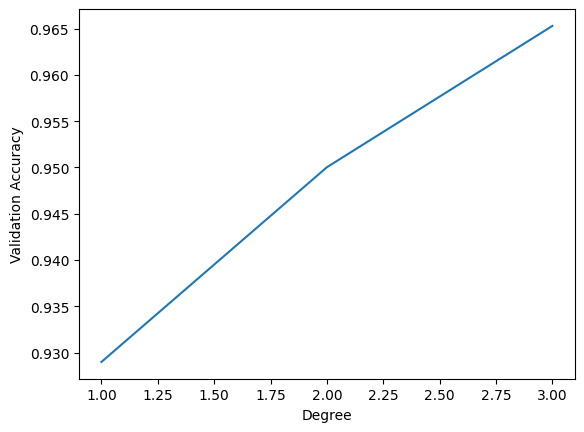

Best degree of polynomial: 3


In [18]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
validation_scores = []

for degree in range(1, 4):
    avg_score = []
    for train_index, val_index in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        poly = PolynomialFeatures(degree)
        X_train_poly = poly.fit_transform(X_train_fold)
        X_val_poly = poly.transform(X_val_fold)

        y_2d_train_fold = y_train_fold.reshape(-1, 1)
        y_2d_val_fold = y_val_fold.reshape(-1, 1)

        w = Gradient_Ascent(X_train_poly, y_2d_train_fold, learning_rate, num_iters)

        y_hat = predict_class(X_val_poly, w, 0.5)
        score = accuracy_score(y_2d_val_fold, y_hat)
        avg_score.append(score)

    validation_scores.append(np.mean(avg_score))

plt.plot(range(1, 4), validation_scores)
plt.xlabel("Degree")
plt.ylabel("Validation Accuracy")
plt.show()

# Find the best degree of polynomial
best_degree = np.argmax(validation_scores) + 1
print("Best degree of polynomial:", best_degree)

In [19]:
poly = PolynomialFeatures(3)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

w = Gradient_Ascent(X_train_poly, y_2d_train, learning_rate, num_iters)

y_hat = predict_class(X_test_poly, w, 0.5)
score = accuracy_score(y_2d_test, y_hat)
print(f"Accuracy with 3rd degree polynomial on test data: {score*100}%")

Accuracy with 3rd degree polynomial on test data: 96.24604251469923%


The best degree of polynomial transformations is the 3rd degree. From degree 2 to 3, there was no major increase in accuracy with the validation set and the amount of features were increasing rapidly, and as a result, computation took too long and was just not viable to train with our machines. 

Continuing forward, we will test regularization techniques to see if we can boost accuracy. We will utilize KFold Validation again to obtain hyperparameters for our regularization. 

We will also continue with the dataset with a 3rd degree polynomial transformation.

In [20]:
def Gradient_Ascent_L1_Regularization(X, y, learning_rate, num_iters, lambda1):
    N = X.shape[0]
    w = np.zeros((X.shape[1],1))
    
    # Gradient Ascent - local optimization technique
    for _ in range(num_iters):
        w = w + (learning_rate / N) * (X.T.dot(y - hypothesis(X, w)))
        w += (lambda1 / N) * np.sign(w)

    return w

def Gradient_Ascent_L2_Regularization(X, y, learning_rate, num_iters, lambda2):
    N = X.shape[0]
    w = np.zeros((X.shape[1],1))
    
    # Gradient Ascent - local optimization technique
    for _ in range(num_iters):
        w = w + (learning_rate / N) * (X.T.dot(y - hypothesis(X, w)))
        w += (lambda2 / N) * w

    return w

In [21]:
poly = PolynomialFeatures(3)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [22]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
validation_scores = []

for lambda1 in [0.001, 0.01, 0.1]:
    avg_score = []
    for train_index, val_index in kfold.split(X_train_poly):
        X_train_fold, X_val_fold = X_train_poly[train_index], X_train_poly[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        y_2d_train_fold = y_train_fold.reshape(-1, 1)
        y_2d_val_fold = y_val_fold.reshape(-1, 1)

        w = Gradient_Ascent_L1_Regularization(X_train_fold, y_2d_train_fold, learning_rate, num_iters, lambda1)

        y_hat = predict_class(X_val_fold, w, 0.5)
        score = accuracy_score(y_2d_val_fold, y_hat)
        avg_score.append(score)
    validation_scores.append(np.mean(avg_score))

plt.plot([0.001, 0.01, 0.1], validation_scores)
plt.xlabel("Lambda")
plt.ylabel("Validation Accuracy")
plt.show()

# Find the best lambda for L1 regularization
best_lambda1 = [0.001, 0.01, 0.1][np.argmax(validation_scores)]
print("Best lambda for L1 regularization:", best_lambda1)

In [ ]:
w = Gradient_Ascent_L1_Regularization(X_train_poly, y_2d_train, learning_rate, num_iters, best_lambda1)

y_hat = predict_class(X_test_poly, w, 0.5)
score = accuracy_score(y_2d_test, y_hat)
print(f"Accuracy with 3rd degree polynomial and L1 regularization with lambda=0.01 on test data: {score*100}%")

Accuracy with 3rd degree polynomial and L1 regularization with lambda=0.01 on test data: 96.20081411126186%


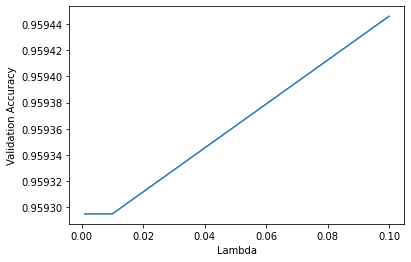

Best lambda for L2 regularization: 0.1


In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
validation_scores = []

for lambda2 in [0.001, 0.01, 0.1]:
    avg_score = []
    for train_index, val_index in kfold.split(X_train_poly):
        X_train_fold, X_val_fold = X_train_poly[train_index], X_train_poly[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        y_2d_train_fold = y_train_fold.reshape(-1, 1)
        y_2d_val_fold = y_val_fold.reshape(-1, 1)

        w = Gradient_Ascent_L2_Regularization(X_train_fold, y_2d_train_fold, learning_rate, num_iters, lambda2)

        y_hat = predict_class(X_val_fold, w, 0.5)
        score = accuracy_score(y_2d_val_fold, y_hat)
        avg_score.append(score)
    validation_scores.append(np.mean(avg_score))

plt.plot([0.001, 0.01, 0.1], validation_scores)
plt.xlabel("Lambda")
plt.ylabel("Validation Accuracy")
plt.show()

# Find the best lambda for L1 regularization
best_lambda1 = [0.001, 0.01, 0.1][np.argmax(validation_scores)]
print("Best lambda for L2 regularization:", best_lambda1)

In [ ]:
w = Gradient_Ascent_L2_Regularization(X_train_poly, y_2d_train, learning_rate, num_iters, best_lambda1)

y_hat = predict_class(X_test_poly, w, 0.5)
score = accuracy_score(y_2d_test, y_hat)
print(f"Accuracy with 3rd degree polynomial and L2 regularization with lambda=0.1 on test data: {score*100}%")

Accuracy with 3rd degree polynomial and L2 regularization with lambda=0.1 on test data: 96.20081411126186%


With L1 Regularization: 0.01 is the best lambda value for our model

With L2 Regularization: 0.1 is the best lambda value for our model

L1 Regularization Accuracy on Test Data: 96.20081411126186%

L2 Regularization Accuracy on Test Data: 96.20081411126186%

Results:

Our modeled performed best with a 3rd degree polynomial transformation. Utilizing regularization with the 3rd degree polynomial transformation did not improve the model any significant amount.

Conclusion: The best accuracy we were able to obtain is 96.20081411126186%.